# **Viet Fact Check Base Line Model**

## **Prepare enviroment**

In [2]:
# Dùng để tải file env. và file requirements. txt chạy trên colab
from google.colab import files
from dotenv import load_dotenv

print("Chọn file .env để upload")
uploaded = files.upload()  # chọn file .env từ máy
load_dotenv(".env") # load biến môi trường từ file .env

Chọn file .env để upload


Saving .env to .env (1)


True

In [3]:
print("Choose file requirements.txt to upload")
uploaded = files.upload()  # chọn file requirements.txt từ máy
load_dotenv("requirements.txt") # load danh sách thư viện từ file requirements.txt

Choose file requirements.txt to upload


Saving requirements.txt to requirements (1).txt


True

In [4]:
!pip install -r requirements.txt --upgrade

In [5]:
import os
from dotenv import load_dotenv
from azure.ai.inference import ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.inference.models import SystemMessage, UserMessage

In [6]:
load_dotenv(".env") # load biến môi trường từ file .env
endpoint = "https://models.github.ai/inference"
model = "openai/gpt-4o-mini"
token = os.environ["GITHUB_TOKEN"]

client = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(token),
)

## **I. Input & Preprocessing**

- Input: Một đoạn văn bản ngắn tiếng Việt.
- Output: Đoạn văn bản tiếng Việt đã được tiền xử lý đưa về tiếng Việt chuẩn phổ thông.

In [7]:
import os
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv

load_dotenv(".env") # load biến môi trường từ file .env

SYSTEM_PROMPT = "Ghi lại những gì người dùng nhập vào nhưng đúng chính tả và ngữ pháp. Đối với các từ viết tắt hãy ghi ra đầy đủ. Những từ lóng, teencode, từ tiếng Việt nhưng viết không dấu, ... hãy chuyển về ngôn ngữ phổ thông."

INPUT_TEXT = """Troi oi, hom nay nong qua di
Tôi tin rằng biến đổi khí hậu đang làm thời tiết cực đoan hơn.
Bn khỏe hông
Nhiệt độ toàn cầu đã tăng 1.1°C trong 100 năm qua"""

PROCESSED_TEXT = ""

endpoint = "https://models.github.ai/inference"
model = "openai/gpt-4o-mini"
token = os.environ["GITHUB_TOKEN"]

client = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(token),
)

response = client.complete(
    messages=[
        SystemMessage(SYSTEM_PROMPT),
        UserMessage(INPUT_TEXT),
    ],
    model=model
)

PROCESSED_TEXT=response.choices[0].message.content

print(PROCESSED_TEXT)

Trời ơi, hôm nay nóng quá đi.  
Tôi tin rằng biến đổi khí hậu đang làm thời tiết cực đoan hơn.  
Bạn khỏe không?  
Nhiệt độ toàn cầu đã tăng 1,1°C trong 100 năm qua.


- [Hướng dẫn sử dụng API của Github hỗ trợ](https://www.youtube.com/watch?v=YP8mV_2RDLc)
- [Github Models Usage Guide](https://docs.github.com/en/github-models/use-github-models/prototyping-with-ai-models#rate-limits)

## **II. Claim Detection**

- Input: Đoạn văn bản tiếng Việt đã được tiền xử lý đưa về tiếng Việt chuẩn phổ thông.
- Output: Đoạn văn bản chứa các claim (khẳng định, luận điểm, sự thật có thể kiểm chứng) đã lược bỏ phần dư thừa và không cần thiết.

In [8]:
import os
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

SYSTEM_PROMPT = """
Bạn là mô-đun Claim Detection.

Nhiệm vụ:
- Giữ lại và trả về những câu có chứa claim: phát biểu khẳng định, luận điểm hoặc sự thật có thể kiểm chứng đúng/sai.
- Bỏ đi các câu cảm thán, chào hỏi, xã giao hoặc câu không chứa claim.

Yêu cầu chi tiết:
- Một claim phải là một mệnh đề có thông tin khách quan, có thể kiểm chứng được (fact hoặc assertion).
- Nếu câu có chứa từ ngữ như "tôi tin rằng", "theo tôi nghĩ", "có lẽ", hãy bỏ phần mở đầu đó và chỉ giữ lại nội dung khẳng định chính.
- Kết quả cần giữ nguyên ngữ pháp, chính tả, tiếng Việt chuẩn."""

CLAIM_TEXT = ""

endpoint = "https://models.github.ai/inference"
model = "openai/gpt-4o-mini"
token = os.environ["GITHUB_TOKEN"]

client = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(token),
)

response = client.complete(
    messages=[
        SystemMessage(SYSTEM_PROMPT),
        UserMessage(PROCESSED_TEXT),
    ],
    model=model
)

CLAIM_TEXT = response.choices[0].message.content

print(CLAIM_TEXT)

Biến đổi khí hậu đang làm thời tiết cực đoan hơn.  
Nhiệt độ toàn cầu đã tăng 1,1°C trong 100 năm qua.


## **III. Document Retrieval**

- Input: Danh sách các claim (chuỗi văn bản tiếng Việt ngắn) được tạo ra từ Module 2 (sau khi đã tiền xử lý và tách các khẳng định có thể kiểm chứng).
- Output: Tập hợp kết quả truy xuất tài liệu cho từng claim bao gồm tiêu đề, đường dẫn, và đoạn mô tả ngắn (snippet) của các bài viết từ Google Search.

In [9]:
!pip install tldextract
!pip install ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0


In [10]:
import os
import json
import re
import time
from dotenv import load_dotenv
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import tldextract
from sentence_transformers import SentenceTransformer, util
from ddgs import DDGS

from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

load_dotenv()
embedder = SentenceTransformer("keepitreal/vietnamese-sbert")
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")

MODEL = "openai/gpt-4o-mini"
client = ChatCompletionsClient(
    endpoint="https://models.github.ai/inference",
    credential=AzureKeyCredential(GITHUB_TOKEN),
)

TRUSTED_DOMAINS = [
    # Việt Nam
    "vnexpress.net", "tuoitre.vn", "thanhnien.vn", "nhandan.vn",
    "moh.gov.vn", "suckhoedoisong.vn", "zingnews.vn",
    "vietnamnet.vn", "baochinhphu.vn", "cafef.vn", "monre.gov.vn",

    # Quốc tế
    "bbc.com", "reuters.com", "apnews.com", "theguardian.com",
    "cnn.com", "nytimes.com", "who.int", "un.org",
    "worldbank.org", "nature.com", "sciencedirect.com"
]

BAD_DOMAINS = [
    # Blog cá nhân & nền tảng tạo blog miễn phí
    "blogspot", "wordpress", "weebly", "wixsite", "jimdo", "tumblr",

    # Mạng xã hội & chia sẻ video
    "facebook", "twitter", "tiktok", "instagram", "youtube", "reddit", "pinterest",

    # Diễn đàn, hỏi đáp, chia sẻ linh tinh
    "voz.vn", "quora", "reddit", "kenh14", "webtretho", "otofun", "tinhte.vn",

    # Trang từ điển / wiki không chính thống
    "tudientiengviet", "wiktionary", "vi.wiktionary", "tratu.soha.vn", "vdict",

    # Trang học sinh – chia sẻ bài làm / học liệu chưa kiểm chứng
    "hocmai", "loigiaihay", "olm.vn", "giaibaitap", "baitap123", "hoc24",

    # Nguồn tin rác / spam nội dung tổng hợp
    "eva.vn", "2sao.vn", "afamily.vn", "tiin.vn", "yeah1", "bestie.vn", "blogtamsu",
]

# 1. Sinh truy vấn mở rộng (tự động hoặc thủ công)
def expand_query(claim: str) -> list[str]:
    """Sinh các biến thể tìm kiếm từ claim."""
    prompt = f"""
    Sinh ra 3-5 phiên bản khác nhau của câu truy vấn sau để tìm kiếm web.
    - Viết lại tự nhiên, cùng nghĩa.
    - Không thêm ý mới.
    - Giữ ngắn gọn, phù hợp tìm kiếm.

    Truy vấn gốc: "{claim}"

    Trả về JSON array duy nhất như:
    ["biến thể 1", "biến thể 2", "biến thể 3", ...]
    """

    response = client.complete(
        messages=[
            SystemMessage("Bạn chỉ trả về JSON array, KHÔNG có giải thích."),
            UserMessage(prompt)
        ],
        model=MODEL,
        temperature=0.7
    )

    content = response.choices[0].message.content.strip()

    try:
        expanded = json.loads(content)
        if not isinstance(expanded, list):
            raise ValueError
    except Exception:
        m = re.search(r'\[.*\]', content, re.S)
        expanded = json.loads(m.group(0)) if m else [claim]

    expanded += [
        claim,
        f"{claim} site:vnexpress.net OR site:tuoitre.vn OR site:thanhnien.vn "
        f"OR site:nhandan.vn OR site:moh.gov.vn OR site:suckhoedoisong.vn"
    ]
    return list(dict.fromkeys(expanded))

# 2. DuckDuckGo Search
def duckduckgo_search(query: str, num_results: int = 5) -> list[dict]:
    results = []
    try:
        with DDGS() as ddgs:
            for r in ddgs.text(query, max_results=num_results):
                results.append({
                    "title": r.get("title", ""),
                    "link": r.get("href", ""),
                    "snippet": r.get("body", "")
                })
    except Exception as e:
        print(f"[DuckDuckGo error] {query[:40]}...: {e}")
    return results[:num_results]

# 3. Tính độ tin cậy (Trust Score)
def compute_trust_score(claim: str, source: dict) -> float:
    """Tính điểm tin cậy (trust_score) cho nguồn tin dựa trên:
    - sim: độ tương đồng ngữ nghĩa giữa claim và snippet (0–1)
    - overlap: tỉ lệ trùng lặp từ khóa giữa claim và snippet
    - domain_bonus: cộng điểm nếu domain uy tín (+0.25)
    - penalty: trừ điểm nếu domain kém tin cậy (-0.3)
    - lang_bonus: cộng nếu snippet là tiếng Việt (+0.1), trừ nếu không (-0.1)
    => trust_score = 0.5*sim + 0.2*overlap + domain_bonus + lang_bonus - penalty
    (giới hạn trong [0,1])
    """
    link = source.get("link", "")
    snippet = source.get("snippet", "")
    domain = tldextract.extract(link).top_domain_under_public_suffix

    # Semantic similarity
    try:
        emb_claim = embedder.encode(claim, convert_to_tensor=True)
        emb_snip = embedder.encode(snippet, convert_to_tensor=True)
        sim = util.cos_sim(emb_claim, emb_snip).item()
    except Exception:
        sim = 0.0

    # Keyword overlap
    claim_words = set(re.findall(r'\w+', claim.lower()))
    snip_words = set(re.findall(r'\w+', snippet.lower()))
    overlap = len(claim_words & snip_words) / len(claim_words) if claim_words else 0

    # Domain-based reward / penalty
    domain_bonus = 0
    penalty = 0

    if any(d in domain for d in TRUSTED_DOMAINS):
        domain_bonus += 0.25
    elif any(d in domain for d in BAD_DOMAINS):
        penalty += 0.3

    # Language bonus (phát hiện tiếng Việt)
    vietnamese_chars = re.findall(r'[àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]', snippet)
    lang_bonus = 0.1 if len(vietnamese_chars) > 5 else -0.1  # trừ nếu snippet không phải tiếng Việt

    # Tổng hợp (chuẩn hóa 0–1)
    trust_score = 0.5 * sim + 0.2 * overlap + domain_bonus + lang_bonus - penalty
    trust_score = max(0, min(trust_score, 1))  # giới hạn [0,1]
    return round(trust_score, 3)

# 4. Pipeline cho 1 claim
def process_claim(claim: str) -> list[dict]:
    queries = expand_query(claim)
    print(f"\n=== Claim: {claim}")
    print(f"Sinh {len(queries)} truy vấn mở rộng.\n")

    results = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(duckduckgo_search, q): q for q in queries}
        for f in tqdm(as_completed(futures), total=len(futures), desc=f"Tìm kiếm '{claim[:40]}...'"):
            results.extend(f.result())
            time.sleep(0.1)

    # Lọc trùng link và loại bỏ link không hợp lệ
    filtered = []
    seen = set()
    for r in results:
        link = r.get("link")
        if not link or not link.startswith("http"):
            continue
        if link in seen:
            continue
        seen.add(link)

        domain = tldextract.extract(link).top_domain_under_public_suffix

        if not domain:  # bỏ link rác
            continue

        filtered.append(r)

    # Tính trust score
    for src in filtered:
        src["trust_score"] = compute_trust_score(claim, src)

    sorted_sources = sorted(filtered, key=lambda x: x["trust_score"], reverse=True)
    return sorted_sources[:5]

# 5. Chạy toàn bộ pipeline
def run_pipeline(claims: list[str]):
    all_results = []
    for claim in claims:
        claim = claim.strip()
        if not claim:
            continue
        sources = process_claim(claim)
        all_results.append({
            "claim": claim,
            "sources": sources
        })

    output_file = "document_retrieval_results_duckduckgo_v2.json"
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2)
    print(f"\nHoàn tất! Kết quả được lưu tại: {output_file}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
claims = [c.strip() for c in CLAIM_TEXT.split("\n") if c.strip()]
run_pipeline(claims)


=== Claim: Biến đổi khí hậu đang làm thời tiết cực đoan hơn.
Sinh 7 truy vấn mở rộng.




Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...':   0%|          | 0/7 [00:00<?, ?it/s]
Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...':  14%|█▍        | 1/7 [00:00<00:04,  1.49it/s]
Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...':  29%|██▊       | 2/7 [00:01<00:02,  1.96it/s]
Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...':  43%|████▎     | 3/7 [00:01<00:01,  2.12it/s]
Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...':  57%|█████▋    | 4/7 [00:01<00:01,  2.46it/s]
Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...':  71%|███████▏  | 5/7 [00:02<00:01,  1.84it/s]
Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...':  86%|████████▌ | 6/7 [00:02<00:00,  2.50it/s]
Tìm kiếm 'Biến đổi khí hậu đang làm thời tiết cực ...': 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]



=== Claim: Nhiệt độ toàn cầu đã tăng 1,1°C trong 100 năm qua.
Sinh 6 truy vấn mở rộng.



Tìm kiếm 'Nhiệt độ toàn cầu đã tăng 1,1°C trong 10...': 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]



Hoàn tất! Kết quả được lưu tại: document_retrieval_results_duckduckgo_v2.json


## **IV. Evidence Selection**

In [12]:
!pip install playwright
!pip install playwright-stealth
!playwright install
!playwright install-deps
!pip install pdfplumber
!pip install trafilatura

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 14.1 MB/s eta 0:00:00
173.7 MiB [] 0% 0.0s173.7 MiB [] 0% 37.4s173.7 MiB [] 0% 57.4s173.7 MiB [] 0% 68.2s173.7 MiB [] 0% 78.2s173.7 MiB [] 0% 82.9s173.7 MiB [] 0% 87.8s173.7 MiB [] 0% 89.1s173.7 MiB [] 0% 92.4s173.7 MiB [] 0% 95.1s173.7 MiB [] 0% 95.5s173.7 MiB [] 0% 96.7s173.7 MiB [] 0% 98.5s173.7 MiB [] 0% 98.9s173.7 MiB [] 0% 100.3s173.7 MiB [] 0% 101.6s173.7 MiB [] 0% 101.8s173.7 MiB [] 0% 102.5s173.7 MiB [] 0% 102.9s173.7 MiB [] 0% 103.0s173.7 MiB [] 0% 103.8s173.7 MiB [] 0% 104.4s173.7 MiB [] 0% 105.1s173.7 MiB [] 0% 88.9s173.7 MiB [] 0% 61.4s173.7 MiB [] 1% 31.9s173.7 MiB [] 2% 23.7s173.7 MiB [] 3% 16.5s173.7 MiB [] 3% 14.5s173.7 MiB [] 4% 13.6s173.7 MiB [] 4% 12.4s173.7 MiB [] 4% 12.0s173.7 MiB [] 5% 11.0s173.7 MiB [] 5% 11.2s173.7 MiB [] 5% 11.4s173.7 MiB [] 6% 10.7s173.7 MiB [] 6% 10.1s173.7 MiB [] 7% 9.6s173.7 MiB [] 7% 9.0s173.7 MiB [] 8% 8.6s173.7 MiB [] 9% 8.2s173.7 MiB [] 9% 8.1s173.7 MiB [] 9% 8.0s173.7 MiB [] 10%

In [13]:
import requests
from pdfminer.high_level import extract_text
import asyncio
import aiohttp
import json

In [14]:
async def extract_text_from_pdf(url: str, session: aiohttp.ClientSession) -> str | None:
    """
    Tải file PDF từ URL và trích xuất văn bản nhanh bằng pdfminer.six (dùng session async)
    """
    print(f"  -> Detect PDF link. Handle by pdfminer.six: {url}")
    try:
        async with session.get(url, timeout=60) as response:
            if response.status != 200:
                print(f"❌ Failed to download PDF ({response.status})")
                return None

            data = await response.read()

        text = extract_text(io.BytesIO(data))
        print("✅ SUCCESS! Extracted text using pdfminer.six ---")
        return text.strip()

    except Exception as e:
        print(f"❌ Error when open file PDF {url}: {e}")
        return None

In [15]:
from playwright.async_api import async_playwright
from playwright_stealth import Stealth
import trafilatura

In [16]:
async def extract_text_from_web(url: str, session: aiohttp.ClientSession) -> str | None:
    """
    Thử dùng trafilatura để trích xuất nội dung trước, nếu có lỗi
    thì dùng Playwright hoặc Stealth Playwright để lấy nội dung HTML.
    """
    print(f"  -> Detect web link. Handle by Trafilatura: {url}")

    try:
        # Fetch HTML bằng session (nhanh hơn nhiều so với trafilatura.fetch_url)
        async with session.get(url, timeout=30) as resp:
            if resp.status != 200:
                raise ValueError(f"HTTP {resp.status}")
            html_content = await resp.text()

        text = trafilatura.extract(html_content)
        if text:
            print("✅ SUCCESS! Extracted text using Trafilatura ---")
            return text

        raise ValueError("Trafilatura extraction return None")

    except Exception as e:
        print(f"⚠️ Error using Trafilatura for URL {url}: {e}")
        print(f"Falling back to Playwright extraction ...")

        try:
            async with async_playwright() as p:
                browser = await p.chromium.launch(headless=True)
                page = await browser.new_page()

                await page.goto(url, timeout=15000, wait_until="domcontentloaded")
                html_content = await page.content()
                await browser.close()

                if not html_content:
                    return None

                # Nếu bị Cloudflare block, fallback stealth
                if "Cloudflare Ray ID" in html_content:
                    print("⚠️ Detected Cloudflare! Retrying with Stealth...")
                    async with Stealth().use_async(async_playwright()) as p2:
                        browser = await p2.chromium.launch(headless=True)
                        page = await browser.new_page()
                        await page.goto(url, timeout=20000)
                        html_content = await page.content()
                        await browser.close()

                main_text = trafilatura.extract(html_content, include_comments=False)
                print(f"✅ SUCCESS! Extracted text using Playwright ---")
                return main_text

        except Exception as e1:
            print(f"❌ Error using Playwright extraction for URL {url}: {e1}")
            return None

In [17]:
async def fetch_content_from_url(url: str, session: aiohttp.ClientSession) -> str | None:
    """
    Hàm điều phối: Kiểm tra loại URL và gọi hàm xử lý tương ứng.
    """
    if url.lower().endswith('.pdf'):
        return await extract_text_from_pdf(url, session)
    else:
        return await extract_text_from_web(url, session)

In [18]:
import re

def clean_text(text: str) -> str:
    """
    Hàm để làm sạch văn bản thô:
    - Loại bỏ URL và địa chỉ email.
    - Thay thế nhiều ký tự xuống dòng, tab bằng một dấu cách.
    - Xóa các dấu cách thừa.
    """
    if not text:
        return ""

    # Loại bỏ URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Loại bỏ địa chỉ email
    text = re.sub(r'\S+@\S+', '', text)

    # Thay thế các ký tự xuống dòng, tab, và các loại khoảng trắng khác bằng một dấu cách
    text = re.sub(r'[\n\r\t\xa0]+', ' ', text)

    # Thay thế nhiều dấu cách liên tiếp bằng một dấu cách duy nhất
    text = re.sub(r'\s{2,}', ' ', text)

    # Xóa dấu cách ở đầu và cuối chuỗi
    return text.strip()

In [19]:
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunk_text(text: str, chunk_size: int = 512, chunk_overlap: int = 50) -> list[str]:
    """Hàm tiện ích để chia văn bản dài thành các chunk nhỏ hơn."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    return text_splitter.split_text(text)

In [20]:
async def process_claims_parallel(retrieved_data):
    evidence_by_claim = {}
    claims = list(retrieved_data.keys())

    async with aiohttp.ClientSession() as session:
        for claim in claims:
            print(f"\n{'='*50}\nHandle claim: '{claim}'")
            documents = retrieved_data[claim]
            all_chunks_for_this_claim = []

            # Gom tất cả link cần crawl
            urls = [doc['link'] for doc in documents]

            # Chạy crawl song song
            print(f"  -> Crawling {len(urls)} links in parallel...")
            tasks = [fetch_content_from_url(u, session) for u in urls]
            full_contents = await asyncio.gather(*tasks)

            # Ghép kết quả với từng doc
            for doc, full_content in zip(documents, full_contents):
                content_to_process = ""

                if full_content and len(full_content) > 100:
                    print(f"SUCCESS!! {doc['link']}")
                    cleaned_full_content = clean_text(full_content)
                    content_to_process = f"{doc.get('title', '')}. {cleaned_full_content}"
                else:
                    print(f"FAIL!! Using snippet for {doc['link']}")
                    cleaned_snippet = clean_text(doc.get('snippet', ''))
                    content_to_process = f"{doc.get('title', '')}. {cleaned_snippet}"

                # Chia nhỏ nội dung
                chunks = chunk_text(content_to_process)

                # Lưu lại
                for chunk_text_part in chunks:
                    all_chunks_for_this_claim.append({
                        "text": chunk_text_part,
                        "link": doc['link']
                    })

            evidence_by_claim[claim] = all_chunks_for_this_claim
            print(f"==> Finish for claim '{claim}'. Total: {len(all_chunks_for_this_claim)} chunks.")

    return evidence_by_claim

In [21]:
# Tải dữ liệu
with open('document_retrieval_results_duckduckgo_v2.json', 'r', encoding='utf-8') as f:
    retrieved_data = json.load(f)
    retrieved_dict = {
    item["claim"]: item["sources"]
    for item in retrieved_data
}

evidence_by_claim = await process_claims_parallel(retrieved_dict)


Handle claim: 'Biến đổi khí hậu đang làm thời tiết cực đoan hơn.'
  -> Crawling 5 links in parallel...
  -> Detect web link. Handle by Trafilatura: https://vietnam.un.org/vi/175280-nguyên-nhân-và-ảnh-hưởng-của-biến-đổi-khí-hậu
  -> Detect web link. Handle by Trafilatura: https://nhandan.vn/bao-dong-ve-cac-hinh-thai-khi-hau-cuc-doan-post792907.html
  -> Detect web link. Handle by Trafilatura: https://cafef.vn/bien-doi-khi-hau-gay-ra-nhieu-thay-doi-ve-luong-mua-khien-bao-du-doi-hon-188240729100143888.chn
  -> Detect web link. Handle by Trafilatura: https://vnexpress.net/bien-doi-khi-hau-cham-ngoi-cho-thoi-tiet-cuc-doan-the-nao-4739038.html
  -> Detect web link. Handle by Trafilatura: https://vnexpress.net/bien-doi-khi-hau-4796505.html
✅ SUCCESS! Extracted text using Trafilatura ---
✅ SUCCESS! Extracted text using Trafilatura ---
✅ SUCCESS! Extracted text using Trafilatura ---
✅ SUCCESS! Extracted text using Trafilatura ---
✅ SUCCESS! Extracted text using Trafilatura ---
SUCCESS!! https:

In [22]:
HF_TOKEN = os.getenv("HF_TOKEN")

In [23]:
from sentence_transformers import SentenceTransformer, util

print("Downloading Bi-Encoder model...")
bi_encoder = SentenceTransformer('bkai-foundation-models/vietnamese-bi-encoder')

# Dùng để lưu trữ top-k ứng viên cho mỗi claim
retrieved_candidates_by_claim = {}

# 2. Lặp qua từng claim và các chunk tương ứng của nó
for claim, chunks_for_claim in evidence_by_claim.items():
    print(f"\n--- Finding top-k chunk related to claim: '{claim}' ---")

    if not chunks_for_claim:
        print("     No evidence chunk for this claim")
        retrieved_candidates_by_claim[claim] = []
        continue

    # Encode câu claim hiện tại
    claim_embedding = bi_encoder.encode(claim, convert_to_tensor=True)

    # Lấy danh sách văn bản từ các chunk của claim này
    chunk_texts = [chunk['text'] for chunk in chunks_for_claim]

    # Encode tất cả các chunk
    chunk_embeddings = bi_encoder.encode(chunk_texts, convert_to_tensor=True)

    # 3. Tính cosine similarity cho claim này với các chunk của nó
    cosine_scores = util.cos_sim(claim_embedding, chunk_embeddings)[0]

    # 4. Lấy ra top-k ứng viên tiềm năng
    top_k = 20
    # Đảm bảo top_k không lớn hơn số lượng chunk có sẵn
    num_chunks_available = len(chunks_for_claim)
    actual_top_k = min(top_k, num_chunks_available)

    top_results_indices = cosine_scores.argsort(descending=True)[:actual_top_k]

    # Lưu các ứng viên tốt nhất vào danh sách tạm
    top_chunks_for_this_claim = []
    print(f"    Top {actual_top_k} chunk best related for claim '{claim}':")
    for idx in top_results_indices:
        candidate = chunks_for_claim[idx]
        top_chunks_for_this_claim.append(candidate)
        print(f"    - Score: {cosine_scores[idx]:.4f} - {candidate['text'][:150]}...")

    # Lưu kết quả top-k cho claim hiện tại
    retrieved_candidates_by_claim[claim] = top_chunks_for_this_claim

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]


--- Finding top-k chunk related to claim: 'Biến đổi khí hậu đang làm thời tiết cực đoan hơn.' ---
    Top 20 chunk best related for claim 'Biến đổi khí hậu đang làm thời tiết cực đoan hơn.':
    - Score: 0.6599 - VnExpress Biến đổi khí hậu châm ngòi cho thời tiết cực đoan thế nào - Báo VnExpress. 1. Mưa lớn Mỗi khi nhiệt độ trung bình tăng thêm một độ C, khí qu...
    - Score: 0.5544 - sơ tán. Tổng Thư ký WMO Celeste Saulo nêu rõ, các hình thái thời tiết cực đoan do biến đổi khí hậu ngày càng gia tăng và đáng báo động, khởi nguồn từ ...
    - Score: 0.5347 - đảo. Ngoài ra, đại dương hấp thụ cacbon dioxit, giữ cho chúng không bay vào khí quyển. Tuy nhiên quá nhiều cacbon dioxit lại làm tăng tính axit của đạ...
    - Score: 0.5200 - cơ tuyệt chủng trong thời gian tới do biến đổi khí hậu và các yếu tố khác như mất môi trường sống, ô nhiễm... Nhiều hệ sinh thái quan trọng như rừng, ...
    - Score: 0.4627 - này có tác động lớn nhất đến nhiệt độ, do đó các chuyên gia cho rằng thời tiết năm

In [24]:
!pip install py_vncorenlp

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4367 sha256=c82a8eb27f9fc87d0fbcc440ac8efa44d2c3af1a719018b20f8a2fcb2920abcb
  Stored in directory: /root/.cache/pip/wheels/db/e5/ff/f4a1b4ece36e8582db1ca71150a34e987e65df50c35974e9bb
Successfully built py_vncorenlp


In [25]:
from sentence_transformers.cross_encoder import CrossEncoder
import py_vncorenlp
import os

In [26]:
!mkdir /content/vncorenlp_model

In [27]:
print("\nLoading VnCoreNLP word segmenter...")
VNCORENLP_SAVE_DIR = '/content/vncorenlp_model'
if not os.path.exists(os.path.join(VNCORENLP_SAVE_DIR, 'model')):
  py_vncorenlp.download_model(save_dir=VNCORENLP_SAVE_DIR)

if 'rdrsegmenter' not in globals():
    rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=VNCORENLP_SAVE_DIR)
else:
    print("VnCoreNLP segmenter already initialized — reusing existing instance.")

# Tải mô hình Cross-Encoder PhoRanker (Vietnamese)
print("\nDownloading PhoRanker Cross-Encoder model...")
MODEL_ID = 'itdainb/PhoRanker'
MAX_LENGTH = 256
cross_encoder = CrossEncoder(MODEL_ID, max_length=MAX_LENGTH)

# Nếu GPU hỗ trợ FP16
try:
    cross_encoder.model.half()
except Exception as e:
    print(f"Warning: Unable to convert model to FP16 ({e})")

# Reranking bằng mô hình PhoRanker
final_evidence_by_claim = {}

for claim, candidates in retrieved_candidates_by_claim.items():
    print(f"\n--- Reranking evidences for claim: '{claim}' ---")

    if not candidates:
        print("     No candidate to rerank.")
        final_evidence_by_claim[claim] = []
        continue

    # Lấy danh sách văn bản ứng viên
    candidate_texts = [candidate['text'] for candidate in candidates]

    # Tách từ và NỐI LẠI THÀNH CHUỖI
    tokenized_claim = " ".join(rdrsegmenter.word_segment(claim))
    tokenized_candidates = [" ".join(rdrsegmenter.word_segment(text)) for text in candidate_texts]

    # Tạo cặp (claim, candidate) ở dạng chuỗi
    tokenized_pairs = [[tokenized_claim, sent] for sent in tokenized_candidates]

    # Dự đoán điểm liên quan
    cross_scores = cross_encoder.predict(tokenized_pairs)

    # Gộp điểm + dữ liệu ứng viên
    reranked_results = list(zip(cross_scores, candidates))
    reranked_results.sort(key=lambda x: x[0], reverse=True)

    # Giới hạn top-k
    final_top_k = 10
    actual_final_top_k = min(final_top_k, len(candidates))
    final_evidence = reranked_results[:actual_final_top_k]

    # Lưu kết quả
    final_evidence_by_claim[claim] = final_evidence

    print(f"    Top {actual_final_top_k} evidences after reranking:")
    for score, chunk in final_evidence:
        print(f"    - Score: {score:.4f} - {chunk['text']} (Source: {chunk.get('link', 'N/A')})")



Loading VnCoreNLP word segmenter...



config.json:   0%|          | 0.00/814 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]


--- Reranking evidences for claim: 'Biến đổi khí hậu đang làm thời tiết cực đoan hơn.' ---
    Top 10 evidences after reranking:
    - Score: 0.9790 - VnExpress Biến đổi khí hậu châm ngòi cho thời tiết cực đoan thế nào - Báo VnExpress. 1. Mưa lớn Mỗi khi nhiệt độ trung bình tăng thêm một độ C, khí quyển có thể chứa thêm khoảng 7% hơi ẩm. Điều này có thể dẫn tới nhiều hạt mưa và mưa nặng hạt hơn, đôi khi trong thời gian ngắn và khu vực nhỏ. Các nhà khoa học đánh giá liệu sự kiện thời tiết cực đoan có thể quy cho biến đổi khí hậu hay không bằng cách xem xét nguyên nhân từ nhiên và con người. Trong trường hợp mưa lớn ở Dubai, Các tiểu vương quốc Arab thống (Source: https://vnexpress.net/bien-doi-khi-hau-cham-ngoi-cho-thoi-tiet-cuc-doan-the-nao-4739038.html)
    - Score: 0.9487 - sơ tán. Tổng Thư ký WMO Celeste Saulo nêu rõ, các hình thái thời tiết cực đoan do biến đổi khí hậu ngày càng gia tăng và đáng báo động, khởi nguồn từ các hoạt động xâm hại thiên nhiên của con người. Ông kêu gọi t

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import json

In [29]:
print("Downloading module NLI (FEVER-trained)...")
nli_model_name = "vicgalle/xlm-roberta-large-xnli-anli"

tokenizer = AutoTokenizer.from_pretrained(nli_model_name)
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name)

def classify_stance(claim: str, evidence_text: str) -> dict:
    """
    Phân loại lập trường của một bằng chứng so với một claim sử dụng mô hình NLI.
    (Hàm này giữ nguyên y hệt như trong notebook gốc của bạn)
    """
    # Mã hóa cặp (bằng chứng, claim)
    # Premise = evidence_text, Hypothesis = claim

    # Cắt bớt văn bản để tránh lỗi token quá dài
    tokenized_input = tokenizer(evidence_text, claim, return_tensors='pt', truncation=True, max_length=512)

    with torch.no_grad():
        outputs = nli_model(**tokenized_input)

    # Lấy điểm số xác suất cho mỗi nhãn
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()

    # Các mô hình XNLI thường có thứ tự nhãn: [contradiction, neutral, entailment]
    # tương ứng với index [0, 1, 2]
    # (Mô hình Moritz này cũng theo thứ tự đó)
    labels = ['Refute', 'Neutral', 'Support']

    # Tìm nhãn có xác suất cao nhất
    predicted_index = torch.argmax(logits, dim=1).item()
    predicted_label = labels[predicted_index]

    return {
        "stance": predicted_label,
        "score": probabilities[predicted_index],
        "scores_all": {
            "refute": probabilities[0],
            "neutral": probabilities[1],
            "support": probabilities[2]
        }
    }

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [30]:
results_with_stance = {}

for claim, top_evidence in final_evidence_by_claim.items():
    evidence_with_stance = []
    print(f"\n--- Phân loại lập trường cho claim: '{claim}' ---")

    for score, chunk in top_evidence:
        stance_result = classify_stance(claim, chunk['text'])

        evidence_with_stance.append({
            'text': chunk['text'],
            'link': chunk['link'],
            'rerank_score': score,
            'stance': stance_result['stance'],
            'stance_score': stance_result['score'],
            'stance_scores': stance_result['scores_all']
        })
        print(f"  -> Stance: {stance_result['stance']} ({stance_result['scores_all']}): | Text: {chunk['text']}")

    results_with_stance[claim] = evidence_with_stance


--- Phân loại lập trường cho claim: 'Biến đổi khí hậu đang làm thời tiết cực đoan hơn.' ---
  -> Stance: Neutral ({'refute': 0.004481097217649221, 'neutral': 0.6608585715293884, 'support': 0.3346603810787201}): | Text: VnExpress Biến đổi khí hậu châm ngòi cho thời tiết cực đoan thế nào - Báo VnExpress. 1. Mưa lớn Mỗi khi nhiệt độ trung bình tăng thêm một độ C, khí quyển có thể chứa thêm khoảng 7% hơi ẩm. Điều này có thể dẫn tới nhiều hạt mưa và mưa nặng hạt hơn, đôi khi trong thời gian ngắn và khu vực nhỏ. Các nhà khoa học đánh giá liệu sự kiện thời tiết cực đoan có thể quy cho biến đổi khí hậu hay không bằng cách xem xét nguyên nhân từ nhiên và con người. Trong trường hợp mưa lớn ở Dubai, Các tiểu vương quốc Arab thống
  -> Stance: Support ({'refute': 0.0004723505408037454, 'neutral': 0.00014160694263409823, 'support': 0.9993860721588135}): | Text: sơ tán. Tổng Thư ký WMO Celeste Saulo nêu rõ, các hình thái thời tiết cực đoan do biến đổi khí hậu ngày càng gia tăng và đáng báo động, k

## **V. Output**

In [31]:
from collections import Counter
import numpy as np
import os
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

### 1. HÀM TỔNG HỢP KẾT LUẬN (VERDICT)

In [32]:
def aggregate_verdict_weighted(evidence_with_stance):
    """
    Tổng hợp verdict (True / False / Unknown) dựa trên stance_scores có trọng số.
    """
    if not evidence_with_stance:
        return {"verdict": "Unknown", "confidence": 0.0}

    weights = {"Support": 0.0, "Refute": 0.0, "Neutral": 0.0}
    total_weight = 0.0

    for e in evidence_with_stance:
        s = e["stance_scores"]
        rel = e.get("rerank_score", 1.0)  # nếu có rerank_score thì dùng làm trọng số phụ
        weights["Support"] += s["support"] * rel
        weights["Refute"] += s["refute"] * rel
        weights["Neutral"] += s["neutral"] * rel
        total_weight += rel

    # Chuẩn hóa lại tỷ lệ
    ratio = {k: v / total_weight for k, v in weights.items()}

    if ratio["Support"] > 0.5:
        verdict = "True"
    elif ratio["Refute"] > 0.5:
        verdict = "False"
    else:
        verdict = "Unknown"

    confidence = max(ratio.values())
    return {"verdict": verdict, "confidence": confidence, "stance_ratio": ratio}

### 2. HÀM SINH GIẢI THÍCH (JUSTIFICATION)

In [33]:
# Cấu hình Azure LLM (GPT-4o-mini)
endpoint = "https://models.github.ai/inference"
model = "openai/gpt-4o-mini"
token = os.environ["GITHUB_TOKEN"]

client = ChatCompletionsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(token)
)

def explain_factcheck_with_best_evidence(claim, verdict, best_evidence, stance_ratio):
    prompt = f"""
Bạn là trợ lý fact-check trung lập và chính xác.
Dưới đây là thông tin hệ thống đã thu thập:

Claim: "{claim}"
System verdict (tổng hợp): {verdict}
Stance ratio (tổng hợp): {stance_ratio}

Best evidence (đã chọn):
"{best_evidence['text']}"
Nguồn: {best_evidence.get('link','(no link)')}

YÊU CẦU (bắt buộc):
- Dựa vào 'System verdict' và 'Stance ratio' khi viết. KHÔNG được mâu thuẫn với verdict đã cho.
- Nếu best evidence ủng hộ nhưng verdict là Unknown, hãy viết theo cấu trúc:
  "[Nhận định]: (True/False/Unknown)"
  "[Giải thích]: Giải thích ngắn (2 câu). Nếu có mâu thuẫn giữa best evidence và verdict, nêu rõ: 'Mặc dù một bằng chứng mạnh cho thấy..., tổng thể bằng chứng hiện nay vẫn...'"

Viết tiếng Việt, 2-3 câu, trung lập và rõ ràng.
"""
    response = client.complete(
        messages=[
            SystemMessage("Bạn là trợ lý fact-check chuyên nghiệp, không mâu thuẫn với verdict đã cho."),
            UserMessage(prompt)
        ],
        model=model,
        temperature=0.2
    )
    return response.choices[0].message.content.strip()

### 3. SINH KẾT LUẬN & IN KẾT QUẢ

In [34]:
final_results = {}

for claim, evidences in results_with_stance.items():
    if not evidences:
        continue

    # Tính verdict có trọng số
    agg = aggregate_verdict_weighted(evidences)

    # Chọn bằng chứng mạnh nhất (score cao nhất)
    best_evidence = max(evidences, key=lambda e: e["stance_score"])

    # Gọi LLM sinh phần giải thích (theo hướng A: tuân thủ verdict)
    justification = explain_factcheck_with_best_evidence(
        claim,
        agg["verdict"],
        best_evidence,
        agg["stance_ratio"]
    )

    # Lưu kết quả
    final_results[claim] = {
        "claim": claim,
        "verdict": agg["verdict"],
        "confidence": agg["confidence"],
        "stance_ratio": agg["stance_ratio"],
        "best_evidence": best_evidence,
        "justification": justification
    }

    # In ra cho người dùng xem
    print("\n" + "="*80)
    print(f"Claim: {claim}")
    print(f"→ Verdict: {agg['verdict']} (Confidence: {agg['confidence']:.2f})")
    print(f"→ Stance ratio: {agg['stance_ratio']}")
    print(f"→ Best Evidence (score={best_evidence['stance_score']:.2f}):")
    print(f"{best_evidence['text'][:300]}...")
    print(f"[Source: {best_evidence['link']}]")
    print("→ Giải thích kiểm chứng:")
    print(justification)


Claim: Biến đổi khí hậu đang làm thời tiết cực đoan hơn.
→ Verdict: True (Confidence: 0.87)
→ Stance ratio: {'Support': np.float32(0.86512274), 'Refute': np.float32(0.0023346895), 'Neutral': np.float32(0.13254265)}
→ Best Evidence (score=1.00):
sơ tán. Tổng Thư ký WMO Celeste Saulo nêu rõ, các hình thái thời tiết cực đoan do biến đổi khí hậu ngày càng gia tăng và đáng báo động, khởi nguồn từ các hoạt động xâm hại thiên nhiên của con người. Ông kêu gọi thế giới nỗ lực hơn nữa để giảm phát thải khí nhà kính, hạn chế sự nóng lên toàn cầu, qua...
[Source: https://nhandan.vn/bao-dong-ve-cac-hinh-thai-khi-hau-cuc-doan-post792907.html]
→ Giải thích kiểm chứng:
[Nhận định]: True  
[Giải thích]: Bằng chứng cho thấy biến đổi khí hậu đang làm gia tăng các hình thái thời tiết cực đoan, như được nêu bởi Tổng Thư ký WMO. Tổng thể bằng chứng hiện nay hỗ trợ cho tuyên bố rằng biến đổi khí hậu có liên quan đến sự gia tăng tần suất và cường độ của các hiện tượng thời tiết cực đoan.

Claim: Nhiệt độ toà

## **Test Module 4 & 5**

Phần này kiểm thử module 4 và 5 với dữ liệu có sẵn.

In [35]:
# Import thư viện cần thiết
from datasets import load_dataset
from tqdm import tqdm
import json
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

### 1. Tải và xử lý dữ liệu

In [36]:
ds = load_dataset("tranthaihoa/vifactcheck")

# Map nhãn số (0, 1, 2) sang chuỗi (Support, Refute, Neutral)
label_map = {
    0: "Support",
    1: "Refute",
    2: "Neutral"
}

ds = ds.map(lambda x: {"label": label_map.get(x["labels"], x["labels"])})

README.md:   0%|          | 0.00/853 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/8.07M [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5062 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/723 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1447 [00:00<?, ? examples/s]

Map:   0%|          | 0/5062 [00:00<?, ? examples/s]

Map:   0%|          | 0/723 [00:00<?, ? examples/s]

Map:   0%|          | 0/1447 [00:00<?, ? examples/s]

### 2. Chạy hệ thống fact-check (Module 4 & 5)

In [37]:
results = []

for sample in tqdm(ds["test"], desc="Đánh giá trên test set"):
    claim = sample["Statement"]
    evidence = sample["Evidence"]
    gold_label = sample["label"]

    # --- Hệ thống dự đoán stance ---
    stance_pred = classify_stance(claim, evidence)
    system_pred = stance_pred["stance"]

    results.append({
        "claim": claim,
        "evidence": evidence,
        "gold_label": gold_label,
        "system_pred": system_pred,
        "stance_score": stance_pred["score"]
    })

Đánh giá trên test set: 100%|██████████| 1447/1447 [23:41<00:00,  1.02it/s]


### 3. Đánh giá độ chính xác


Báo cáo đánh giá mô hình (Fact-Check Dataset Match):
              precision    recall  f1-score   support

     Neutral      0.826     0.864     0.844       471
      Refute      0.894     0.829     0.860       468
     Support      0.825     0.844     0.835       508

    accuracy                          0.846      1447
   macro avg      0.848     0.846     0.846      1447
weighted avg      0.848     0.846     0.846      1447



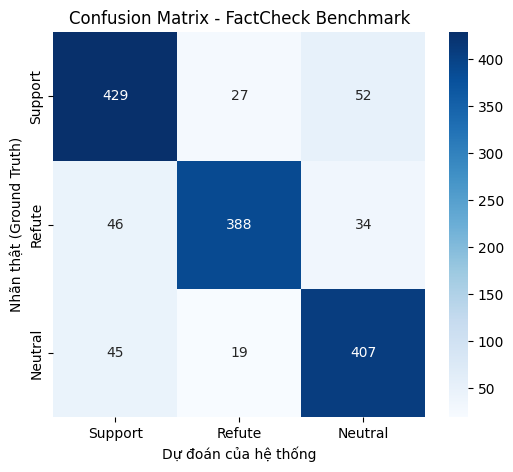

In [39]:
y_true = [r["gold_label"] for r in results]
y_pred = [r["system_pred"] for r in results]

print("\nBáo cáo đánh giá mô hình (Fact-Check Dataset Match):")
print(classification_report(y_true, y_pred, digits=3))

# --- Vẽ confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=["Support", "Refute", "Neutral"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Support", "Refute", "Neutral"],
            yticklabels=["Support", "Refute", "Neutral"])
plt.xlabel("Dự đoán của hệ thống")
plt.ylabel("Nhãn thật (Ground Truth)")
plt.title("Confusion Matrix - FactCheck Benchmark")
plt.show()